In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import math
from tqdm import tqdm
import matplotlib.patches as patches

In [2]:
post_path = 'v1_voff_post.fits'
post_cube  = fits.open(post_path)
post_data = post_cube[0].data
post_header = post_cube[0].header

wcs_posterior = wcs.WCS(post_header)

Velocity Resolution: 0.020100486924400585 kms
1.0


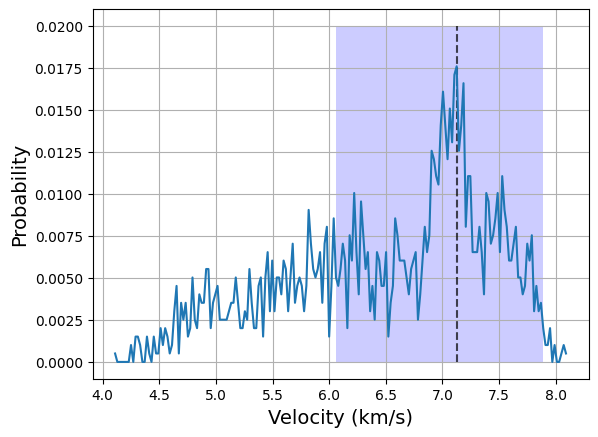

In [3]:
vel_start = post_header["CRVAL3"]
vel_inc = post_header["CDELT3"]

v_channels = np.arange(post_header["NAXIS3"])

#define velocity as km/s blocks
velocity = vel_start + (vel_inc * v_channels)
velocity = np.array(velocity, dtype = float)

print('Velocity Resolution:', velocity[1]-velocity[0], 'kms')

posterior_dist = post_data[:, 70, 1069]
print(np.sum(posterior_dist))

fig, ax = plt.subplots()
plt.vlines(velocity[150], 0, 0.02, color = 'black', linestyle = 'dashed', alpha = 0.7)
plt.plot(velocity, posterior_dist)
plt.xlabel('Velocity (km/s)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
rect = patches.Rectangle((velocity[97], 0), 91*0.020100486924400585, 0.02, facecolor='blue', alpha=0.2)
ax.add_patch(rect)

#plt.ylim(-0.005, 0.079)
plt.grid()
#plt.savefig('example_posterior_width3.png', transparent=True, bbox_inches = 'tight')

In [59]:
posterior_dist = post_data[:, 70, 1069]

# Find the index of the maximum value
max_index = np.argmax(posterior_dist)
print(max_index)

# Initialize variables
sum_values = posterior_dist[max_index]
included_indices = [max_index]

# Initialize pointers to move outward
left, right = max_index - 1, max_index + 1

# Start summing values moving outward
while sum_values < 0.68 and (left >= 0 or right < len(posterior_dist)):
    if left >= 0 and (right >= len(posterior_dist) or posterior_dist[left] >= posterior_dist[right]):
        sum_values += posterior_dist[left]
        included_indices.append(left)
        left -= 1
    elif right < len(posterior_dist):
        sum_values += posterior_dist[right]
        included_indices.append(right)
        right += 1

# Sort the indices for readability
included_indices.sort()

# Print the indices
print("Indices included in the sum:", [int(x) for x in included_indices])
print(included_indices[-1] - included_indices[0])


150
Indices included in the sum: [97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]
91


In [32]:
width = []
for i in tqdm(range(800)):
    row_number = []
    for j in range(2200):
        posterior_dist = post_data[:, i, j]
        if math.isnan(np.max(posterior_dist)):
            row_number.append(np.max(posterior_dist))
        else:
            # Find the maximum value
            max_index = np.argmax(posterior_dist)

            # Initialize variables
            sum_values = posterior_dist[max_index]
            included_indices = [max_index]

            # Initialize pointers to move outward
            left, right = max_index - 1, max_index + 1

            # Start summing values moving outward
            while sum_values < 0.68 and (left >= 0 or right < len(posterior_dist)):
                if left >= 0 and (right >= len(posterior_dist) or posterior_dist[left] >= posterior_dist[right]):
                    sum_values += posterior_dist[left]
                    included_indices.append(left)
                    left -= 1
                elif right < len(posterior_dist):
                    sum_values += posterior_dist[right]
                    included_indices.append(right)
                    right += 1

            # Sort the indices for readability
            included_indices.sort()

            row_number.append((included_indices[-1] - included_indices[0])*(velocity[1] - velocity[0]))
    width.append(row_number)

100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 56.38it/s]


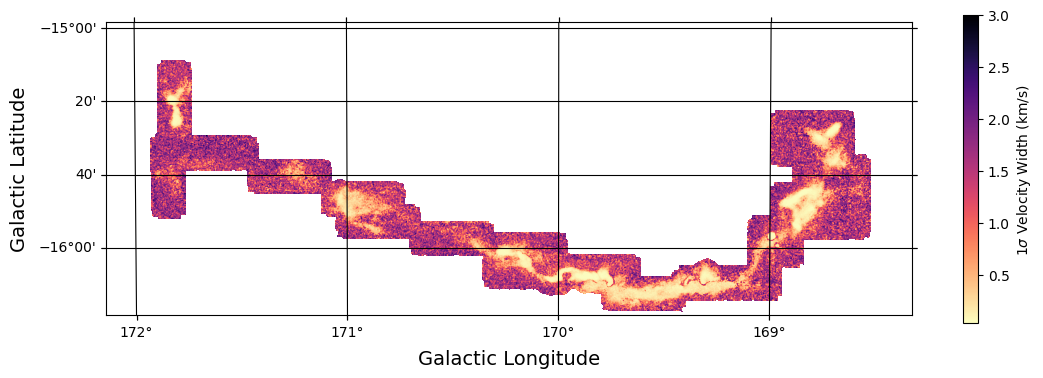

In [35]:
plt.figure(figsize = [13,4])
ax = plt.subplot(projection=wcs_posterior, slices=('x', 'y', 0))
#cm = plt.cm.get_cmap('bwr_r')
plt.imshow(width, origin = 'lower', cmap = 'magma_r', vmax = 3)
plt.colorbar(label = r'1$\sigma$ Velocity Width (km/s)')
plt.grid()

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Galactic Longitude', fontsize = 14)
ax.coords[1].set_axislabel('Galactic Latitude', fontsize = 14)

plt.savefig('width_map.png', transparent=True, bbox_inches = 'tight')

In [37]:
path_masked = 'masked_ML_velocity.fits'
cube_masked = fits.open(path_masked)
data_masked = cube_masked[0].data
header_masked = cube_masked[0].header

wcs_masked_vel = wcs.WCS(header_masked)

In [38]:
masked_width = []
for i in tqdm(range(800)):
    row_number = []
    for j in range(2200):
        masked_vals = data_masked[i, j] 
        if math.isnan(np.max(masked_vals)):
            row_number.append(np.max(masked_vals))
        else:
            row_number.append(width[i][j])
    masked_width.append(row_number)

output_hdu = wcs_masked_vel.to_fits()
output_hdu[0].data is None

output_hdu[0].data = masked_width

output_hdu.writeto("masked_width.fits", overwrite=True)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:05<00:00, 140.79it/s]


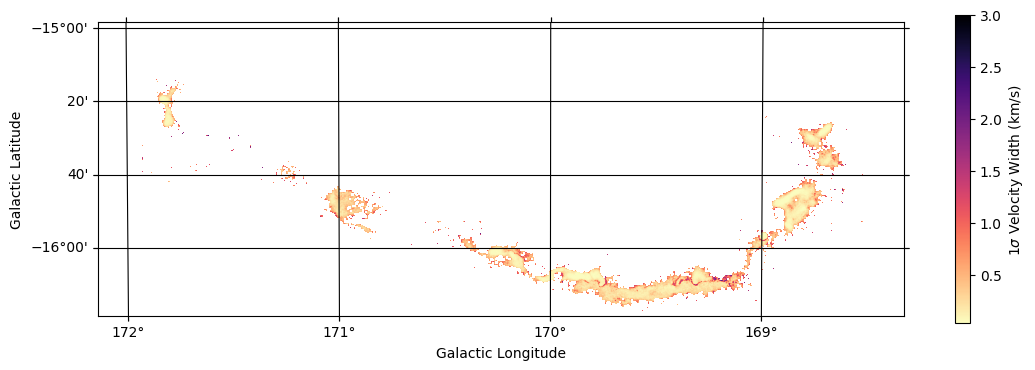

In [39]:
plt.figure(figsize = [13,4])
ax = plt.subplot(projection=wcs_posterior, slices=('x', 'y', 0))
#cm = plt.cm.get_cmap('bwr_r')
plt.imshow(masked_width, origin = 'lower', cmap = 'magma_r', vmax = 3)
plt.colorbar(label = r'1$\sigma$ Velocity Width (km/s)')
plt.grid()

ax.coords.grid(True, color='black', ls='solid')
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

In [40]:
region = 'B213'
path = region + '_velocity_posterior.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header

wcs_subregion = wcs.WCS(header)

path = 'distance_transform.fits'
cube = fits.open(path)
distance_transform_data = cube[0].data
header = cube[0].header

wcs_dist_transform = wcs.WCS(header)

path = 'masked_width.fits'
cube = fits.open(path)
masked_width_data = cube[0].data
header = cube[0].header

wcs_masked_width = wcs.WCS(header)

170.3131659755382 169.7184408938772
-16.190000391798 -15.978333720009001
1053.0000000000043 1395.9999999999973
70.0 197.0
nan


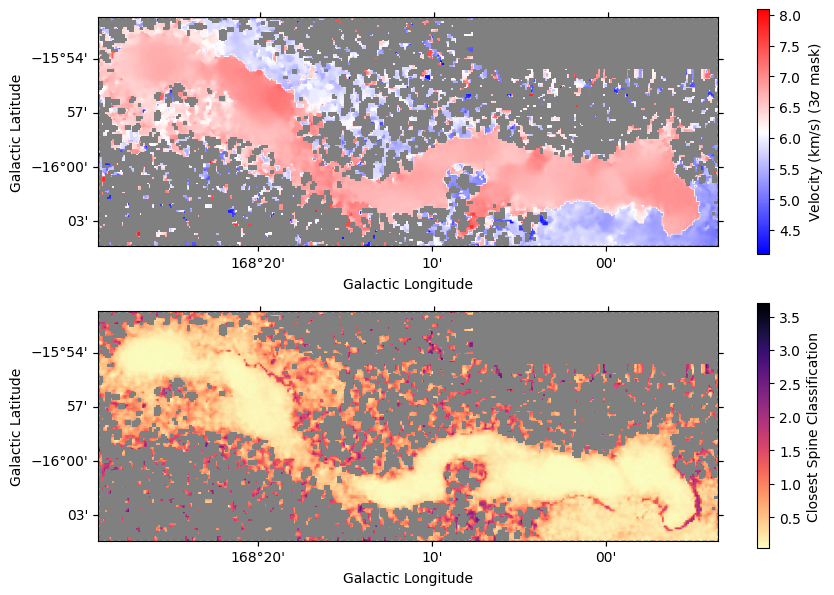

In [41]:
longitude = [135, #B7
            249, #B216
            173, #B218
            343, #B213
            353, #B211
            169 #B10
            ]
latitude = [169, #B7
           169, #B216
           163, #B218
           127, #B213
           133, #B211
           178 #B10
           ]

if region == 'B7':
    index = 0
elif region == 'B216':
    index = 1
elif region == 'B218':
    index = 2
elif region == 'B213':
    index = 3
elif region == 'B211':
    index = 4
elif region == 'B10':
    index = 5

(l_min, b_min, vel), (l_max, b_max, vel) = wcs_subregion.wcs_pix2world([[0, 0, 0], [longitude[index], latitude[index], 0]], 0)

print(l_min, l_max)
print(b_min, b_max)

(l_min_pix, b_min_pix, vel), (l_max_pix, b_max_pix, vel) = wcs_masked_vel.wcs_world2pix([[l_min, b_min, vel], [l_max, b_max, vel]], 0)

print(l_min_pix, l_max_pix)
print(b_min_pix, b_max_pix)

plt.figure(figsize = [10, 7])
ax_1 = plt.subplot(211, projection = wcs_subregion, slices=('x', 'y', 0))
im = ax_1.imshow(data_masked, cmap = 'bwr')
#plt.scatter(pixels_x, pixels_y, s = 15, c = 'purple', marker = '*')
ax_1.set_facecolor("grey")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_1.set(xlim=(round(l_min_pix), round(l_max_pix)), ylim=(round(b_min_pix), round(b_max_pix)))
cbar = plt.colorbar(im, label = r'Velocity (km/s) (3$\sigma$ mask)')
#ax_1.text(1360, 180, 'B213', fontsize = 16, fontweight = 'bold')
ax_1.add_patch(plt.Rectangle((round(l_min_pix) + 0, round(b_min_pix) + 0), longitude[index], latitude[index], ls="--", ec="k", fc="none"))

ax_2 = plt.subplot(212, projection = wcs_subregion, slices=('x', 'y', 0))
im = ax_2.imshow(masked_width, cmap = 'magma_r')
#plt.scatter(pixels_x, pixels_y, s = 15, c = 'purple', marker = '*')
ax_2.set_facecolor("grey")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_2.set(xlim=(round(l_min_pix), round(l_max_pix)), ylim=(round(b_min_pix), round(b_max_pix)))
cbar = plt.colorbar(im, label = r'Closest Spine Classification')
#ax_1.text(1360, 180, 'B213', fontsize = 16, fontweight = 'bold')
ax_2.add_patch(plt.Rectangle((round(l_min_pix) + 0, round(b_min_pix) + 0), longitude[index], latitude[index], ls="--", ec="k", fc="none"))

print(masked_width[10][10])

[(0.0, 342.5), (0.0, 126.5)]

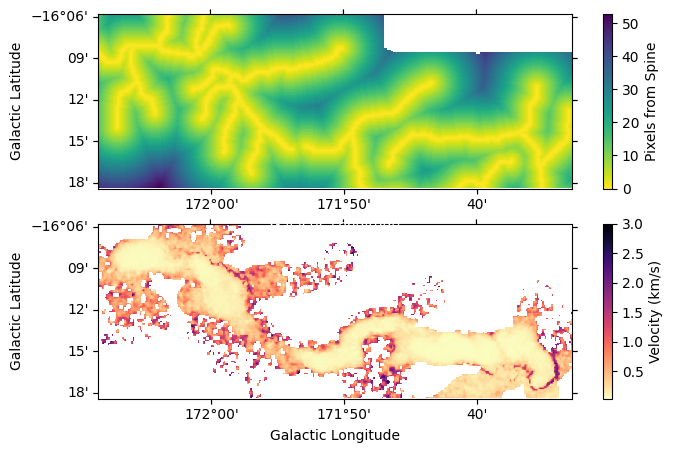

In [42]:
lon_length, lat_length = longitude[index], latitude[index]
lon_start, lat_start = 0, 0

subregion_spines = distance_transform_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]

subregion_widths = masked_width_data[round(b_min_pix + lat_start):round(b_min_pix + lat_start + lat_length), round(l_min_pix + lon_start):round(l_min_pix + lon_start + lon_length)]

width_mag = []
for i in range(lat_length):
    row = []
    for j in range(lon_length):
        if subregion_spines[i][j] <= 12:
            row.append(subregion_widths[i][j])
        else:
            row.append(masked_width[10][10])
    width_mag.append(row)    

plt.figure(figsize = [8, 5])

ax_2 = plt.subplot(212, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_2.imshow(width_mag, cmap = 'magma_r', vmax = 3.0)
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_2.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(211, projection = wcs_masked_vel, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
plt.xlabel('Galactic Longitude', c = 'white')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
ax_1.set(xlim=(0, longitude[index] - 0.5), ylim=(0, latitude[index] - 0.5))

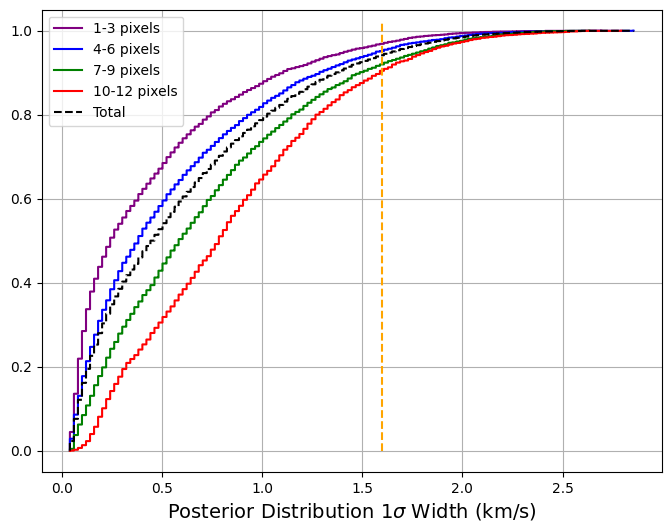

In [47]:
width_low = []
width_med = []
width_high = []
width_higher = []
total_width = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if math.isnan(width_mag[j][i]) == False:
                width_low.append(width_mag[j][i])
                total_width.append(width_mag[j][i])
        elif 4 <= subregion_spines[j][i] <= 6:
            if math.isnan(width_mag[j][i]) == False:
                width_med.append(width_mag[j][i])
                total_width.append(width_mag[j][i])
        elif 7 <= subregion_spines[j][i] <= 9:
            if math.isnan(width_mag[j][i]) == False:
                width_high.append(width_mag[j][i])
                total_width.append(width_mag[j][i])
        elif 10 <= subregion_spines[j][i] <= 12:
            if math.isnan(width_mag[j][i]) == False:
                width_higher.append(width_mag[j][i])
                total_width.append(width_mag[j][i])

plt.figure(figsize = [8, 6])
plt.ecdf(width_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(width_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(width_high, label = '7-9 pixels', color = 'green')
plt.ecdf(width_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_width, label = 'Total', linestyle = 'dashed', color = 'black')
plt.ylim(-0.05, 1.05)
plt.grid()
plt.legend()
plt.vlines(1.6, 0, 1.02, color = 'orange', linestyle = 'dashed')
plt.xlabel(r'Posterior Distribution 1$\sigma$ Width (km/s)', fontsize = 14)

plt.savefig('width_cdf.png', transparent=True, bbox_inches = 'tight')

In [54]:
print(b_min_pix, l_min_pix)
print(len(subregion_widths))

for l in range(len(subregion_widths)):
    for m in range(len(subregion_widths[l])):
        if subregion_widths[l][m] >= 1.5 and math.isnan(subregion_widths[l][m]) == False:
            print(m+int(l_min_pix), l+int(b_min_pix))

70.0 1053.0000000000043
127
1054 70
1059 70
1069 70
1093 70
1101 70
1102 70
1103 70
1104 70
1105 70
1119 70
1121 70
1163 70
1164 70
1167 70
1171 70
1185 70
1186 70
1190 70
1199 70
1200 70
1201 70
1202 70
1203 70
1211 70
1212 70
1223 70
1242 70
1243 70
1257 70
1259 70
1261 70
1262 70
1263 70
1264 70
1272 70
1273 70
1053 71
1054 71
1059 71
1069 71
1101 71
1102 71
1103 71
1105 71
1119 71
1120 71
1122 71
1163 71
1164 71
1165 71
1166 71
1167 71
1170 71
1175 71
1176 71
1184 71
1185 71
1186 71
1198 71
1200 71
1201 71
1202 71
1203 71
1211 71
1212 71
1213 71
1221 71
1243 71
1261 71
1262 71
1263 71
1272 71
1273 71
1069 72
1101 72
1102 72
1104 72
1105 72
1109 72
1118 72
1119 72
1120 72
1121 72
1163 72
1164 72
1165 72
1172 72
1175 72
1183 72
1185 72
1186 72
1198 72
1200 72
1202 72
1203 72
1204 72
1211 72
1212 72
1217 72
1218 72
1222 72
1223 72
1260 72
1261 72
1262 72
1263 72
1272 72
1273 72
1070 73
1101 73
1102 73
1119 73
1120 73
1121 73
1130 73
1170 73
1171 73
1183 73
1184 73
1185 73
1203 73
1217

Text(0, 0.5, 'Probability')

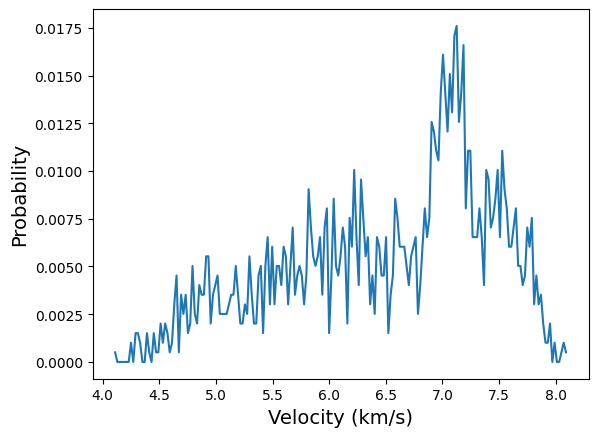

In [57]:
posterior_dist = post_data[:, 70, 1069]

fig, ax = plt.subplots()
#plt.vlines(velocity[49], 0, 0.075, color = 'black', linestyle = 'dashed', alpha = 0.7)
plt.plot(velocity, posterior_dist)
plt.xlabel('Velocity (km/s)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)